# Question 3

## Task 3

### Part 1

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.load('./data/rolls.npy')
np.unique(data), data.shape

(array([0, 1, 2, 3, 4, 5]), (50000, 1))

In [3]:
from hmmlearn import hmm

#### 1. Train an HMM model with a 50 % t...

In [4]:
# Setting random seed
np.random.seed(13)

In [5]:
train_size = len(data) // 2
train_data = data[:train_size]
val_data = data[train_size:]

train_data.shape, val_data.shape

((25000, 1), (25000, 1))

In [19]:
'''
Asked GPT for Experiment with different emission probabilities for the
loaded die and report the model with the best score. Use the validation
split to evaluate the best model.

next code block was returned
NOTE: the code returned was very wrong so I just ended up writing it myself
'''

'\nAsked GPT for Experiment with different emission probabilities for the\nloaded die and report the model with the best score. Use the validation\nsplit to evaluate the best model.\n\nnext code block was returned\nNOTE: the code returned was very wrong so I just ended up writing it myself\n'

In [20]:
fair_probs = np.ones(6) * 1 / 6
best_score = -np.inf
best_model = None

# Training and validation split
train_sequence = train_data.squeeze()
valid_sequence = val_data.squeeze()

# Experiment with different emission probabilities for the loaded die
for prob in range(15):
    # Vary the loaded die probabilities
    loaded_probs = np.random.dirichlet(np.ones(6), size=1)

    # Create the emission matrix
    emission_prob = np.vstack((fair_probs, loaded_probs))

    # Initialize and train the HMM model
    model = hmm.CategoricalHMM(n_components=2, random_state=13, init_params='', n_iter=100)
    '''
        NOTE: I'm also assuming that we have the initial transition matrix
        as without it the probabilities for getting numbers 1 through 6 don;t come same even for fair die
    '''


    model.startprob_ = np.array([1.0, 0.0])  # Start with a fair die
    model.transmat_ = np.array([[0.95, 0.05], [0.05, 0.95]])  # Transition probabilities between fair and loaded
    model.emissionprob_ = emission_prob

    # Fit the model on the training sequence
    model.fit(train_sequence.reshape(-1, 1))

    # Evaluate on validation set
    score = model.score(valid_sequence.reshape(-1, 1))

    # Update best model if score improves
    if score > best_score:
        best_score = score
        best_model = model
        best_emission = emission_prob

In [21]:
# Report the best model and emission probability
print(f"Best score: {best_score}")

best_transition_matrix = best_model.transmat_
best_emission_matrix = best_model.emissionprob_
best_start_probabilities = best_model.startprob_

print(f"Best Transition Matrix:")
print(best_transition_matrix)

print(f"Best Emission Matrix:")
print(best_emission_matrix)

print(f"Best Start Probabilities:")
print(best_start_probabilities)


Best score: -43065.16493386163
Best Transition Matrix:
[[0.89130716 0.10869284]
 [0.1638242  0.8361758 ]]
Best Emission Matrix:
[[0.16246344 0.15517303 0.16518946 0.15968756 0.16249274 0.19499377]
 [0.1011166  0.1106037  0.09790937 0.10108885 0.10588719 0.48339431]]
Best Start Probabilities:
[1. 0.]


#### 2. Find the most likely sequence of switching between the fair and loaded die.

In [22]:
predicted_states = best_model.predict(data)
print(f"Most Likely sequence of switching: {predicted_states}")

Most Likely sequence of switching: [0 0 0 ... 1 1 1]


In [10]:
data_score, data_seq = best_model.decode(data)
print(f"Score on all data: {data_score}")

Score on all data: -92640.11269656743


#### 3. Plot the generated states

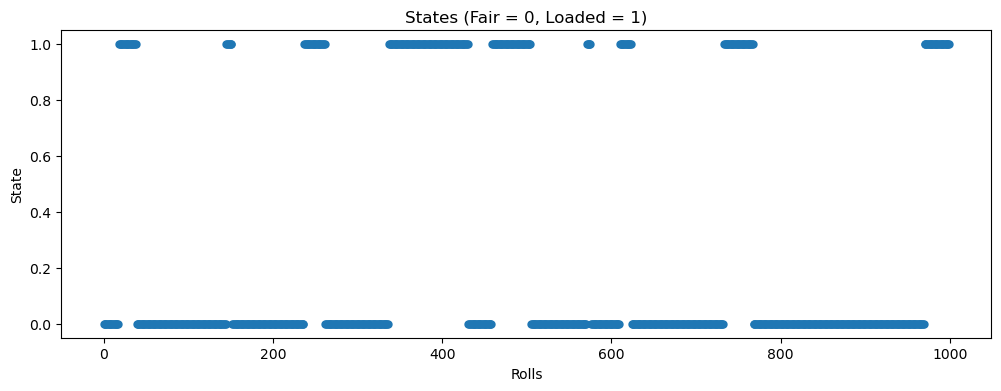

In [11]:
plt.figure(figsize=(12, 4))
plt.plot(data_seq[:1000], marker='o', linestyle=' ', markersize=5)
plt.title('States (Fair = 0, Loaded = 1)')
plt.xlabel('Rolls')
plt.ylabel('State')
plt.show()

#### 4. What problem in Hidden Markov Models does this task correspond to?

- This corresponds to the decoding problem in HMMs
- It deals with the most probabable sequence of hidden states given by the HMM parameters and observation sequence
- We use the model.predict here to predict the sequence
- We set an initial estimate of the model parameters and have the observation sequence which is used to find the most likely sequence. Thus, its the decoding problem as we try to find the most likely sequence by switching between fair and loaded die.

### Part 2

#### 1. How often do you think the casino is switching out the fair die for the loaded one and vice versa?

In [13]:
transition_matrix = best_model.transmat_
fair_to_loaded_prob = transition_matrix[0, 1]
loaded_to_fair_prob = transition_matrix[1, 0]

print("Probability of switching from fair to loaded die:", fair_to_loaded_prob)
print("Probability of switching from loaded to fair die:", loaded_to_fair_prob)

Probability of switching from fair to loaded die: 0.10785866527902654
Probability of switching from loaded to fair die: 0.17029668358473274


The above code provides the probabilities of transitioning from a fair die to a loaded die and from a loaded die to a fair die, based on the trained model. These probabilities indicate how often the casino might be switching the dice during the observed rolls.

In [14]:
states = best_model.predict(valid_sequence.reshape(-1, 1))

fair_to_loaded_count = np.sum((states[:-1] == 0) & (states[1:] == 1))
loaded_to_fair_count = np.sum((states[:-1] == 1) & (states[1:] == 0))

print("Number of times switching from fair to loaded die:", fair_to_loaded_count)
print("Number of times switching from loaded to fair die:", loaded_to_fair_count)

Number of times switching from fair to loaded die: 265
Number of times switching from loaded to fair die: 264


The numbers agree with the probabilities

#### 2. What problem in Hidden Markov Models does this task correspond to?

- this corresponds to the learning problem of HMMs
- it deals with the estimation of the HMM paramaters such that they maximize the likelihood of the observed data given the observation sequence
- Here, we estimate the transition matrix that best describes the data by modelling the switches between the die
- this problem is related to estimating the sequence of hidden states based on the observed sequence of emissions. By examining the transitions between states (fair to loaded and vice versa) using the transition matrix, we aim to estimate the underlying process (switching between fair and loaded dice) that generates the observed data (rolls of the dice).

### Part 3

#### 1. How do you think the loaded die is biased

In [15]:
loaded_die_emission_probs = best_emission[1] 
print("Emission probabilities for the loaded die:")
print(loaded_die_emission_probs)

Emission probabilities for the loaded die:
[0.22948416 0.01078233 0.1463122  0.09748028 0.08951815 0.42642288]


The bias in the loaded die can be inferred from the emission probabilities estimated by the best_model. These emission probabilities represent the likelihood of observing each outcome (1 through 6) given the hidden states (fair or loaded die).

The aforementioned emission probabilities for the loaded die obtained from the best_model shows that the loaded die is biased as the probabilities of getting different faces of the die are very very different - 6th face is being favoures

#### 2. What problem in Hidden Markov Models does this task correspond t

- this corresponds to the learning problem of HMMs
- it deals with the estimation of the HMM paramaters such that they maximize the likelihood of the observed data given the observation sequence
- The problem of understanding the bias in the loaded die based on the estimated emission probabilities corresponds to the "Emission Estimation problem" (Learning) in Hidden Markov Models (HMMs).
- The end goal is to estimate the emission probabilities associated with each outcome (1 through 6) given the hidden states (fair or loaded die). By examining the emission probabilities for the loaded die obtained from the model, we aim to understand how the loaded die is biased toward specific outcomes compared to a fair die. This problem involves inferring the characteristics or biases of the hidden states based on observed emissions, providing insights into the nature of the loaded die.

---

## Task 4

In [9]:
runs = np.load('./data/runs.npy')

In [10]:
'''
    Fed GPT the entire prompt for Task 4
'''

'\n    Fed GPT the entire prompt for Task 4\n'

In [11]:
import numpy as np
from hmmlearn import hmm

runs_flat = runs.flatten()
runs_list = list(runs_flat)

emission_map = {0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 6: 5}
reverse_emission_map = {v: k for k, v in emission_map.items()}
emission_states = list(emission_map.values())

X = np.array([emission_map[run] for run in runs_list]).reshape(-1, 1)

model = hmm.CategoricalHMM(n_components=2, n_iter=100, tol=1e-2, init_params='s', random_state=13)

uncertain_transition_matrix = np.array([[0.7, 0.3], [0.3, 0.7]])

model.transmat_ = uncertain_transition_matrix

'''
To ensure
As a cricket enthusiast, you know Virat is likely to focus on singles and doubles
to anchor the innings. In contrast, Rohit is more prone to taking risky shots to
boost the run rate
'''
virat_em = np.array([0.1, 0.2, 0.2, 0.1, 0.1, 0.1])
virat_em /= np.sum(virat_em)
rohit_em = np.array([0.1, 0.1, 0.1, 0.1, 0.2, 0.2])
rohit_em /= np.sum(rohit_em)
emission_prob = np.vstack((virat_em, rohit_em))
model.emissionprob_ = emission_prob

model.fit(X)

optimal_transition_mat = model.transmat_
optimal_emission_prob = model.emissionprob_
optimal_start_prob = model.startprob_

predicted_states = model.predict(X)

print("Optimal Transmission Matrix:")
print(optimal_transition_mat)
print("\nOptimal Emission Probabilities:")
print(optimal_emission_prob)
print("\nOptimal Start Probabilities:")
print(optimal_start_prob)


Optimal Transmission Matrix:
[[0.69434494 0.30565506]
 [0.27850337 0.72149663]]

Optimal Emission Probabilities:
[[0.15738847 0.30348754 0.25333765 0.04449102 0.14154762 0.09974771]
 [0.09605823 0.10645777 0.10743457 0.05145252 0.35603031 0.2825666 ]]

Optimal Start Probabilities:
[1.00000000e+00 7.00487289e-13]


According to our emmission matrix stack, Virat is 0th index.

In [12]:
first_ball_player = "Virat" if predicted_states[0] == 0 else "Rohit"
last_ball_player = "Virat" if predicted_states[-1] == 0 else "Rohit"

print("\nPredicted player for the first ball:", first_ball_player)
print("Predicted player for the last ball:", last_ball_player)


Predicted player for the first ball: Virat
Predicted player for the last ball: Rohit
